In [1]:
import numpy as np
from M1S_tools import *
import matplotlib.pyplot as plt

%matplotlib inline
plt.jet()

from scipy.interpolate import griddata

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
Afz =  (27685, 170)
Afx =  (27685, 170)
Afy =  (27685, 170)
U matrix (27685, 170)
V matrix (170, 170)
S matrix (170, 170)
N node =  27685


<Figure size 640x480 with 0 Axes>

## At least two things went wrong with this notebook

1. do not use Zernikes. Using 22 Zernikes and inverting the sensitivity matrix is like saying "we've measured these 22-3 numbers. We don't know the higher order Zernikes. The bending modes are free to produce high order Zernikes, as long as they are helping with z4-z22.

2. no need to interpolate onto square grid. The Zernike fits work fine on scattered grid.

In [2]:
n_of_zernikes = 22
#n_of_BMs = 27
n_of_BMs = 46

In [3]:
senM = np.zeros((n_of_zernikes, n_of_BMs))

## set up square grid

In [4]:
n_nodes_along_radius = 100 #number of grid points along radius (including center)
xvec = np.arange(-radius_of_CA, radius_of_CA+1e-6, 
                 radius_of_CA/n_nodes_along_radius)
yvec = np.arange(-radius_of_CA, radius_of_CA+1e-6, 
                 radius_of_CA/n_nodes_along_radius)
x,y = np.meshgrid(xvec, yvec)
r = np.hypot(x,y)
mask = np.zeros_like(r)
mask[r<radius_of_CA]=1
masknan = mask.copy()
masknan[mask==0] = np.nan

xfit = x/radius_of_CA
yfit = y/radius_of_CA

## interpolate bending modes onto square girds to that we can do the decomposition

In [5]:
bm_on_grid = np.zeros((2*n_nodes_along_radius+1, 2*n_nodes_along_radius+1, n_of_BMs))
for modeID in range(1,n_of_BMs+1):
    bm_on_grid[:,:, modeID-1] = griddata(np.hstack((nodex_ml, nodey_ml)), UMat_ml[:,modeID-1], (x, y), 
                                         method='nearest')
    senM[:,modeID-1] = ZernikeMaskedFit(bm_on_grid[:,:,modeID-1], xfit, yfit, n_of_zernikes, mask, 0) #in micron

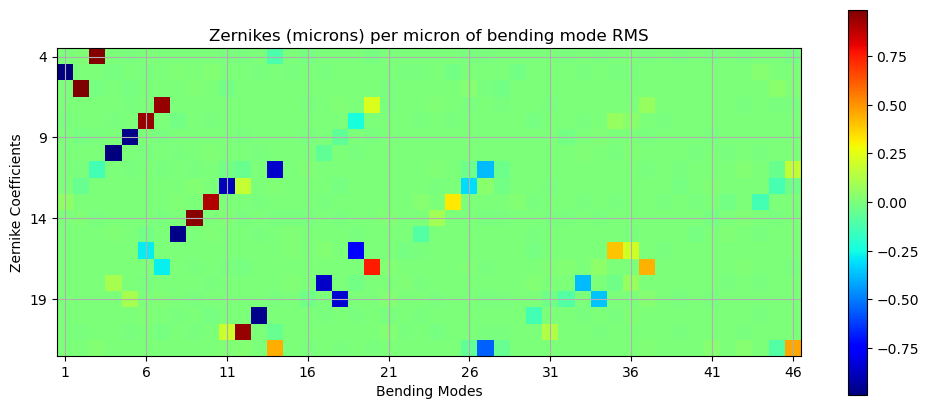

In [11]:
fig, ax = plt.subplots(1,1, figsize=(12,5))

plt.imshow(senM[3:,:n_of_BMs])
plt.grid()
plt.colorbar()
plt.title('Zernikes (microns) per micron of bending mode RMS');
plt.xlabel('Bending Modes')
plt.ylabel('Zernike Coefficients')
plt.yticks(np.arange(0,18,5),['%d'%i for i in np.arange(4,22,5)]);
plt.xticks(np.arange(0,n_of_BMs,5),['%d'%i for i in np.arange(1,n_of_BMs+1,5)]);

In [7]:
#for testing decomposition:
radial_shift_zn = np.zeros(n_of_zernikes)
radial_shift_zn[4-1] = 1

In [131]:
#radial shift
radial_shift_zn = np.zeros(n_of_zernikes)
radial_shift_zn[4-1] = 0.799
radial_shift_zn[6-1] = -0.539 #x astig only, z5 is 45 deg ast, ref rb2Zn.ipynb
radial_shift_zn[7-1] = 0.049 #y coma only, z8 is x coma, ref rb2Zn.ipynb

In [105]:
#clocking
radial_shift_zn = np.zeros(n_of_zernikes)
radial_shift_zn[5-1] = 1.28 #z5 only, ref rb2Zn.ipynb
radial_shift_zn[8-1] = 0.168 #z8 only, ref rb2Zn.ipynb

In [47]:
modes_to_use = [1,1,1,1,1,  1,1,1,1,1,
                1,1,1,1,0,  0,1,1,1,1,
                0,0,0,0,0,  0,1,0,0,0,
                0,0,1,1,1,  1,1,0,0,0,
                0,0,0,0,0,  1]
def truncate_senM(senM):
    aa = np.zeros_like(senM)
    ii = 0
    for imode in np.arange(1,senM.shape[1]+1):
        if modes_to_use[imode-1] == 1:
            aa[:,imode-1] = senM[:,ii]
            ii += 1
    n_column = np.sum(modes_to_use)
    return aa[:,:n_column]

def restore_bm_coeff(coeff):
    aa = np.zeros(senM.shape[1])
    ii = 0
    for imode in np.arange(1,senM.shape[1]+1):
        if modes_to_use[imode-1] == 1:
            #print(imode, ii, coeff[ii])
            aa[imode-1] = coeff[ii]
            ii += 1
    return aa

In [48]:
#test the functions above
aa=np.arange(1,truncate_senM(senM).shape[1]+1)
for i,xx in enumerate(restore_bm_coeff(aa)):
    print(i+1, xx)

1 1.0
2 2.0
3 3.0
4 4.0
5 5.0
6 6.0
7 7.0
8 8.0
9 9.0
10 10.0
11 11.0
12 12.0
13 13.0
14 14.0
15 0.0
16 0.0
17 15.0
18 16.0
19 17.0
20 18.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 19.0


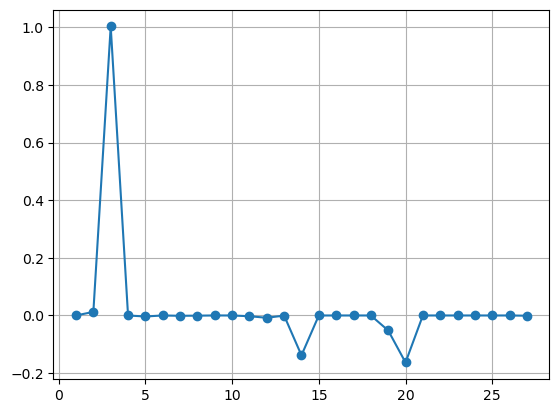

In [49]:
bm_coeff = restore_bm_coeff(np.linalg.pinv(truncate_senM(senM)) @ radial_shift_zn)
plt.plot(np.arange(1,n_of_BMs+1), bm_coeff, '-o')
plt.grid()

In [50]:
bm_coeff

array([ 8.77492224e-05,  1.24182588e-02,  1.00323866e+00, -6.02052262e-05,
       -3.47142432e-03,  4.14251732e-05, -1.10315706e-03, -6.16386063e-04,
        9.08027020e-05,  4.62252395e-06, -2.57110467e-03, -7.98650255e-03,
       -3.56895798e-04, -1.38306319e-01,  0.00000000e+00,  0.00000000e+00,
       -2.34614048e-18, -4.23193953e-18, -5.20144844e-02, -1.63141311e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -7.81788487e-04])

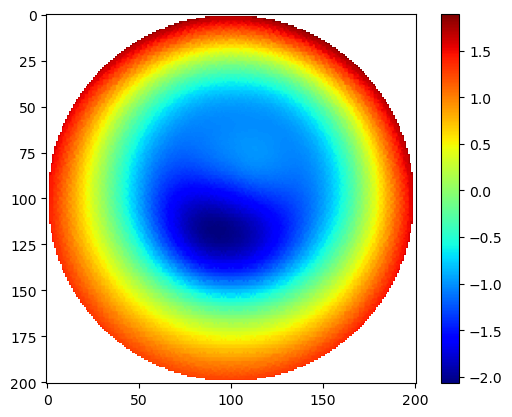

In [51]:
#plt.imshow(ZernikeEval(radial_shift_zn, xfit, yfit))
z_fit = np.zeros_like(x)
force_ml = np.zeros_like(VMat_ml[:,0])
for modeID in range(1,n_of_BMs+1):
    if modeID>0: #==7:
        z_fit += bm_on_grid[:,:,modeID-1]*bm_coeff[modeID-1]
        force_ml += VMat_ml[:, modeID-1]*bm_coeff[modeID-1]
plt.imshow(z_fit*masknan)
plt.colorbar();

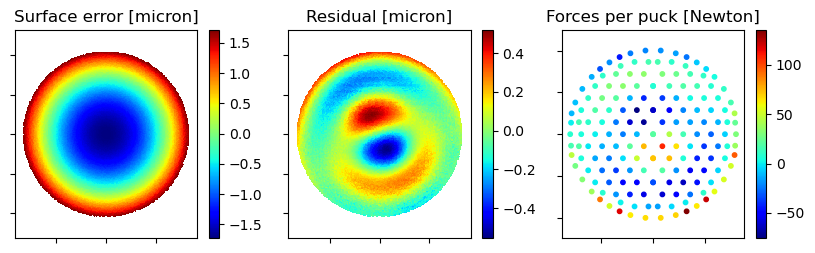

In [52]:
import matplotlib.tri as tri

fig, ax = plt.subplots(1,3, figsize=(10,2.7))

xp = x.flatten()
yp = y.flatten()
triang = tri.Triangulation(xp, yp)

img = ax[0].tripcolor(triang, (ZernikeEval(radial_shift_zn, xfit, yfit)*masknan).flatten())
fig.colorbar(img, ax=ax[0])
ax[0].set_title('Surface error [micron]')
ax[0].axis('equal');
ax[0].xaxis.set_ticklabels([])
ax[0].yaxis.set_ticklabels([])

residual = ZernikeEval(radial_shift_zn, xfit, yfit)*masknan - z_fit*masknan
img = ax[1].tripcolor(triang, residual.flatten())
fig.colorbar(img, ax=ax[1])
ax[1].set_title('Residual [micron]')
ax[1].axis('equal');
ax[1].xaxis.set_ticklabels([])
ax[1].yaxis.set_ticklabels([])

img = ax[2].scatter(sax, say, 10, c=mlFvec2gmtFvec(force_ml)/npuck)
fig.colorbar(img, ax=ax[2])
ax[2].set_title('Forces per puck [Newton]')
ax[2].xaxis.set_ticklabels([])
ax[2].yaxis.set_ticklabels([])
ax[2].axis('equal');

## for reference, let's plot the Zernikes

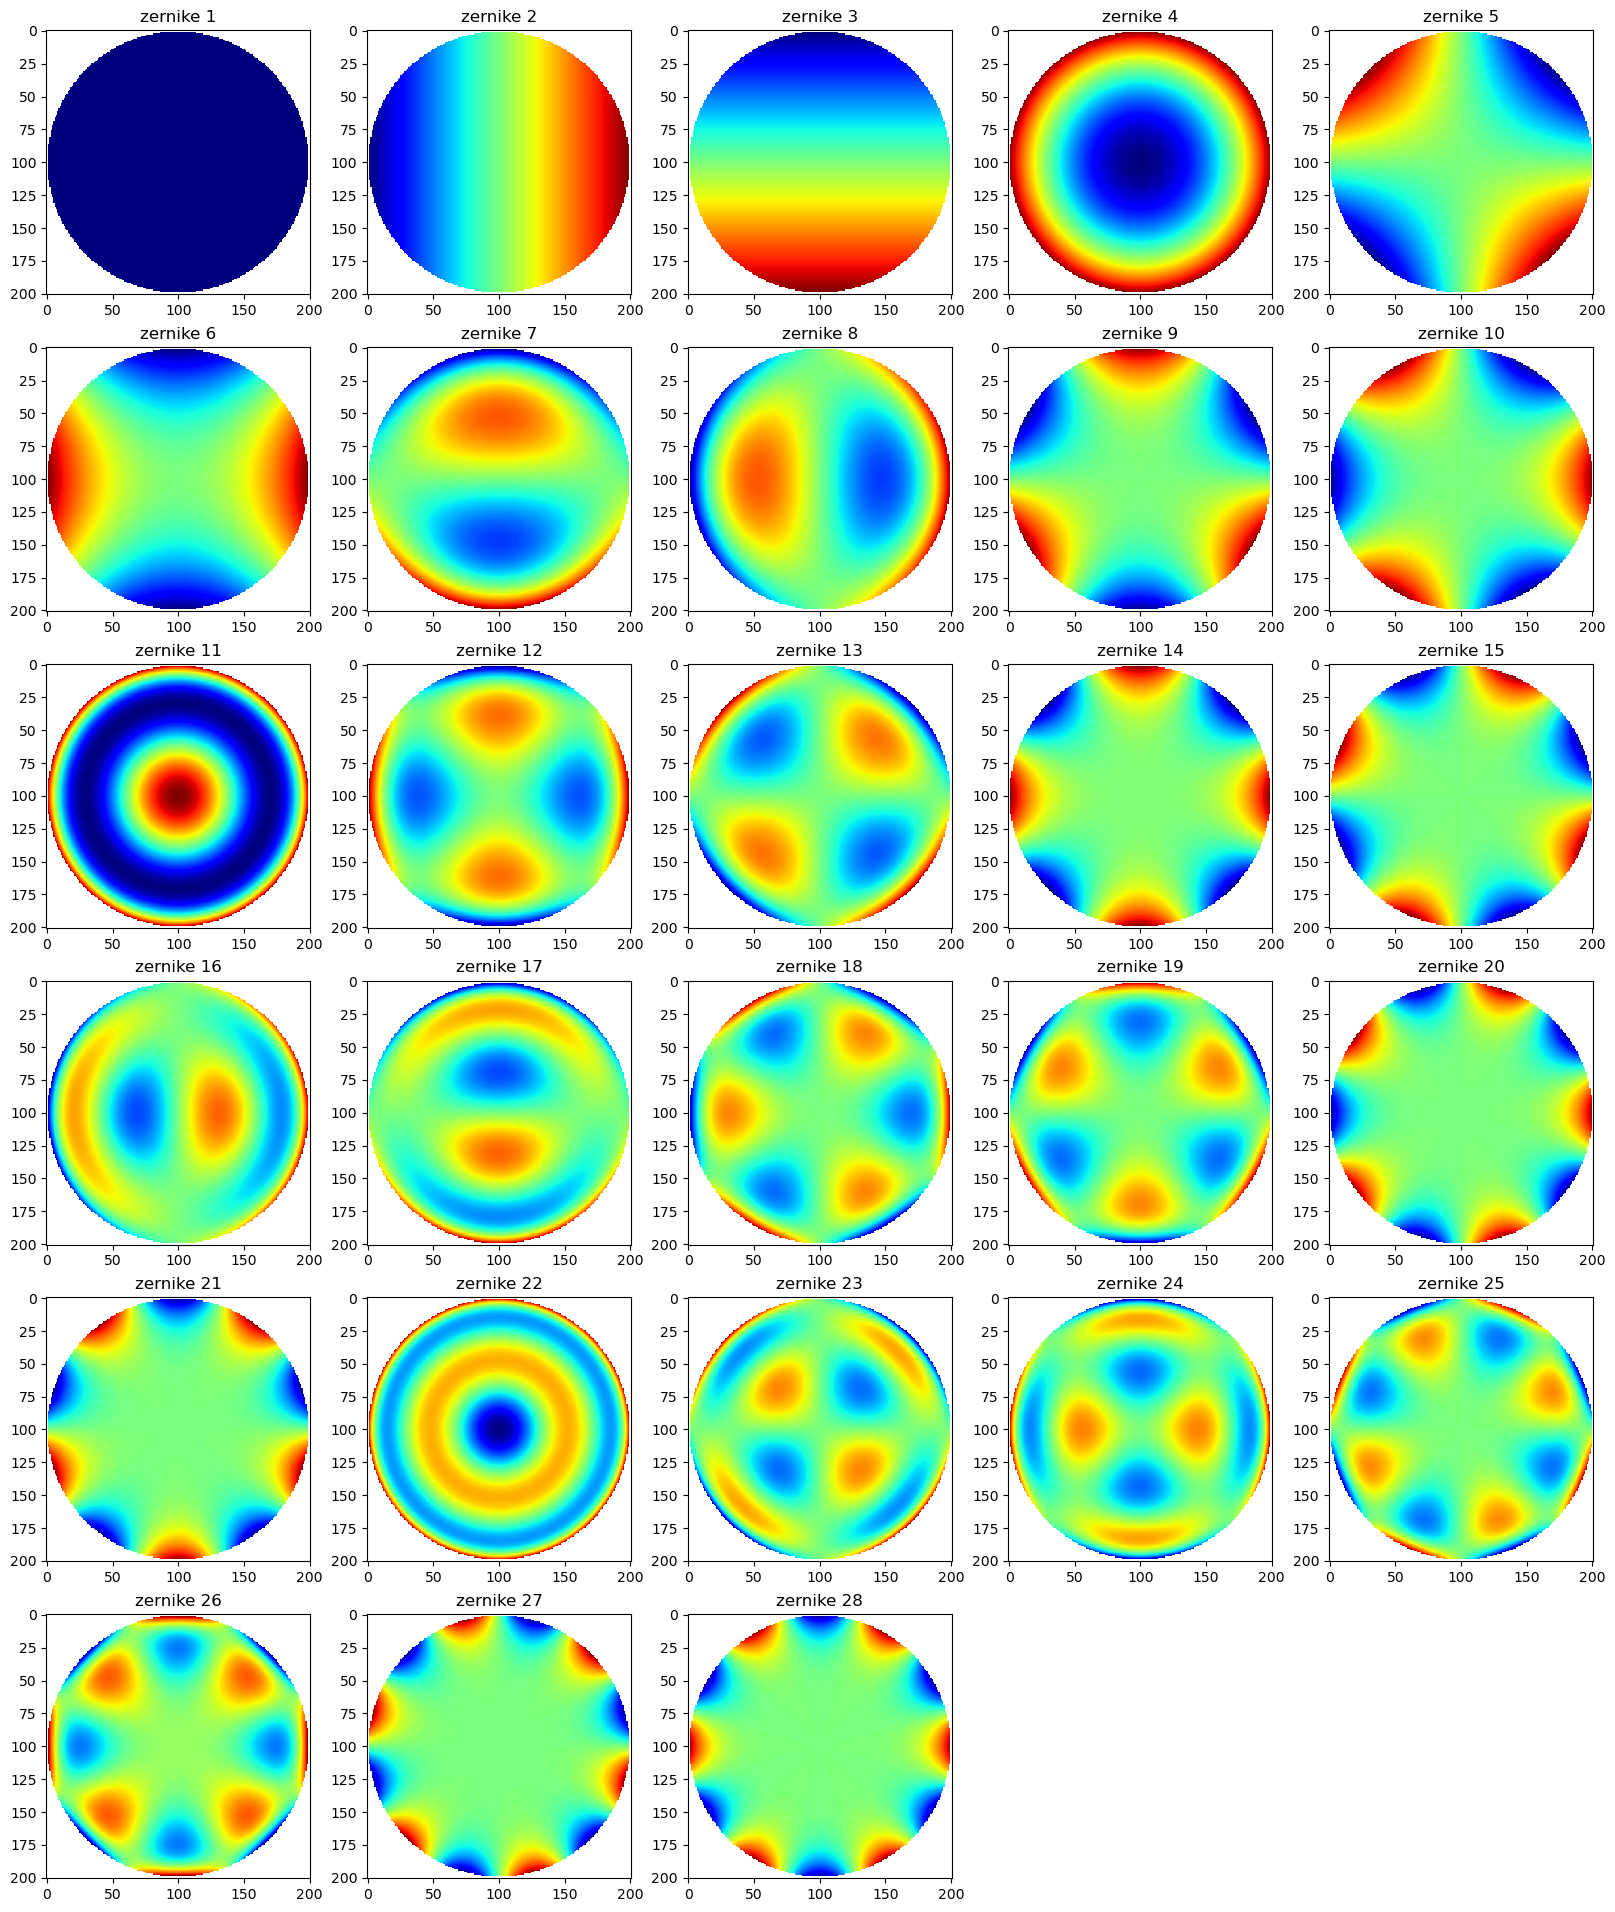

In [121]:
nrow = 6
mode_start = 1
mode_end = 28
fig, ax = plt.subplots(nrow,5,figsize=(20,4*nrow))
i = 0
for modeID in range(mode_start,mode_start+5*nrow):
    irow = np.int8(i/5)
    icol = np.mod(i,5)
    i += 1

    if modeID<=mode_end:
        z_coeff = np.zeros(28)
        z_coeff[modeID-1] = 1
        img = ax[irow][icol].imshow(masknan*ZernikeEval(z_coeff, xfit, yfit))
        ax[irow][icol].set_title('zernike %d'%modeID)
    else:
        ax[irow][icol].axis('off')